In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = [8,6]

### Van der Waals equation of state

$$ p = \frac{R T}{v-b} - \frac{a}{v^2}.$$

Compressibility factor at the critical point '$c$' is
$$ Z_{c} = \frac{p_c v_c}{R T_c} = \frac{3}{8}.$$

Using reduced variables 
$$\bar T = T/T_c,$$
$$\bar p = p/p_c,$$
$$\bar v = v/v_c,$$
and the conditions at the critical point,
$$ \left.\frac{\partial p}{\partial v}\right|_T = 0, $$

$$ \left.\frac{\partial^2 p}{\partial v^2}\right|_T = 0, $$
it can be shown that the VdW parameters for the reduced form are
$$ a = 3, $$
$$ b = 1/3, $$
$$ \bar R = 1/Z_c = \frac{8}{3}. $$

As such the VdW eos can be writen as, 
$$ \bar p = \frac{8\bar T}{3\bar v-1} - \frac{3}{\bar v^2}.$$

In [2]:
class VdW_RF:
    
#     no constructor needed.

    def pressure_tv(self,t,v):
        return 8*t/(3*v-1) - 3/v**2
    
    def specvolume_pt(self,p,t):
        coeff = [p, -1.0/3.0*p - 8.0/3.0*t, 3.0, -1.0]
        v = np.roots(coeff)
        return v

### Peng Robinson equation of state. 
Can be used as a starting point for the homework assignment. 

In [3]:
class PengRobinson:
    
    # constructor needed in case class also stores variables
    # for example: parameters of the Peng Robinson equation of state - also critical conditions. 
    
    def __init__(self,a,b,c,d,R): 
        self.a = a
    
    def pressure_tv(self,t,v):
        return # your own function

### Instantiate the EOS

In [4]:
myeos = VdW_RF()

### Test it

In [5]:
p = myeos.pressure_tv(1.0, 1.0)
print(p)

1.0


### Plot the p-v diagram

Text(0, 0.5, 'reduced pressure $p_r$')

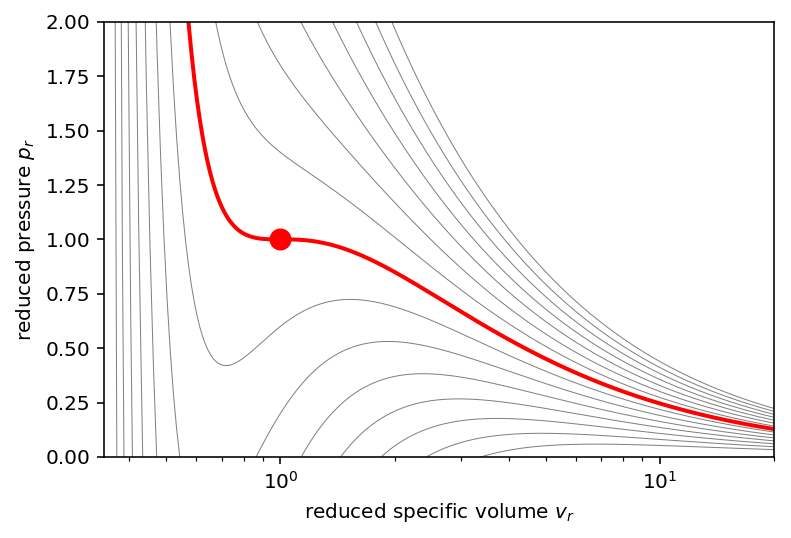

In [6]:
svol = np.linspace(1.0/3.0+1e-2, 100, 10000)
temp = np.linspace(0.3, 1.7, 15)

fig, ax = plt.subplots()

for t in temp: 
    lcolor = [0.5,0.5,0.5]
    lwidth = 0.5
    if t == 1: # plot the critical isotherm in red
        lcolor = 'r'
        lwidth = 2.0
    pres = myeos.pressure_tv(t,svol)
    ax.semilogx(svol,pres,linewidth = lwidth,color=lcolor)
    
ax.semilogx(1,1,'ro', markersize = 10) # plot the critical point

ax.set_xlim(1./3+1e-2,20)
ax.set_ylim(1e-3,2)
ax.set_xlabel("reduced specific volume $v_r$")
ax.set_ylabel("reduced pressure $p_r$")

### Check the roots and prepare for Maxwell's equal are construction of the VLE region

The roots are:  [1.90858876 1.25862012 0.59469587]


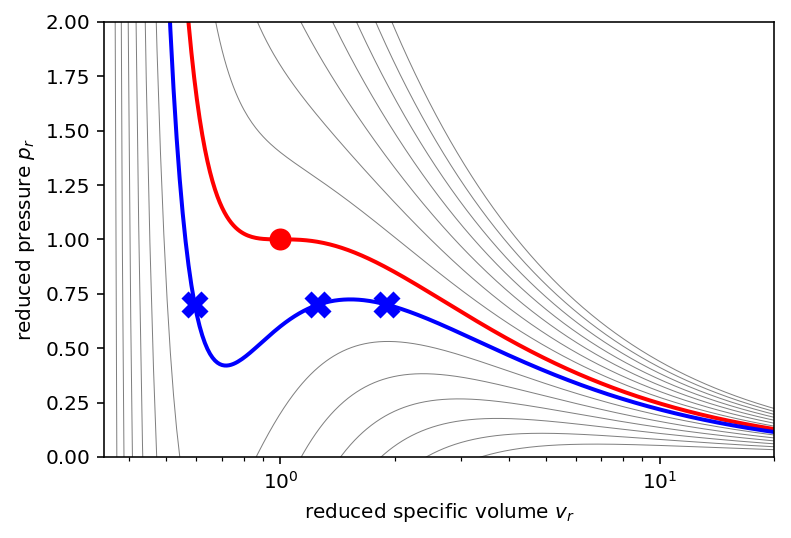

In [7]:
pres = 0.7
temp = 0.9

# plot the isotherm at t = temp
ax.semilogx(svol, myeos.pressure_tv(temp,svol), 'b',linewidth = 2)

# calculate the specific volume for t=temp and p=pres
v = myeos.specvolume_pt(pres, temp)
print("The roots are: ", v)

# plot the roots 
ax.semilogx(np.real(v), [pres,pres,pres], 'xb', markersize = 10, markeredgewidth = 5)

# show figure
fig

### Demonstrate/test the integral: $A_1=\int_{v_1}^{v_2} pdv$ and $A_2=\int_{v_2}^{v_3} pdv$

In [8]:
import scipy.integrate as integrate

v = np.sort(v) 
print("spec. volumes: ", v[0], v[1], v[2])

fun = lambda v: myeos.pressure_tv(t,v) - pres
area1, err = integrate.quad(fun,v[0],v[1])
area2, err = integrate.quad(fun,v[1],v[2])
# area1 = abs()

print("areas: ", area1, area2)

spec. volumes:  0.5946958749396054 1.2586201240859003 1.9085887628792562
areas:  2.6052388959852437 1.1453473014662026


# Maxwell equal area construction

In [9]:
import scipy.integrate as integrate

def calcVLE_t(eos, t):
    p = 1.0
    dp = 0.001
    
    iter = 0
    maxiter = 1000
    area1 = 1.0
    area2 = 0.0
    
    while (abs(area1-area2) > 1.0e-8) and (iter<=maxiter):
        v = eos.specvolume_pt(p,t)
        
        if all(np.imag(v)==0):
            v = np.sort(v)
            fun = lambda x: eos.pressure_tv(t,x) - p
            area1, err = integrate.quad(fun,v[0],v[1])
            area2, err = integrate.quad(fun,v[1],v[2])
            area1 = abs(area1)
            area2 = abs(area2)
            
            if (area1 > area2):     # decrease pressure
                p = p - dp
                if p < 0:           # if p<0 then decrease pressure increment
                    p = p + dp
                    dp = dp/10
                    p = p - dp
            else:
                p = p + dp
                dp = dp/10
                p = p - dp
        else:   
            p = p - dp
            if p < 0:
                p = p + dp
                dp = dp/10
                p = p - dp
            
        iter += 1
        
    return p, v[0], v[2]

### Test it and plot the result

0.6469983589999998 0.6034019035126641 2.3488423908529454


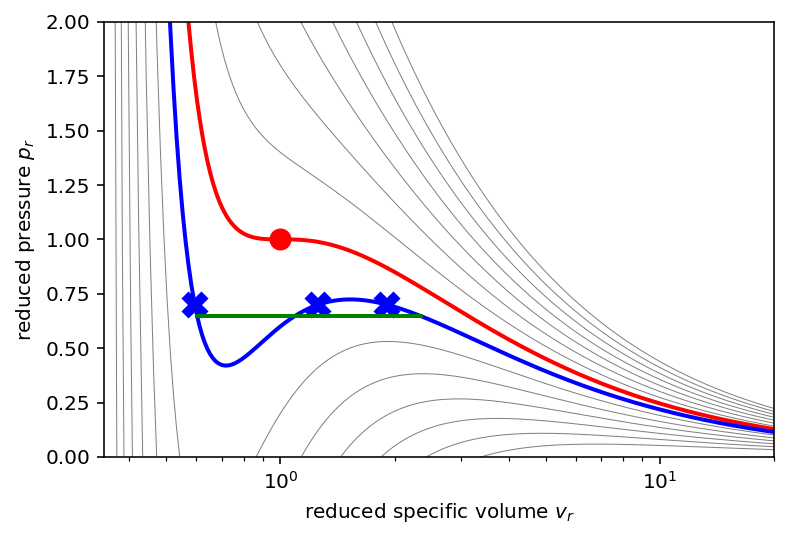

In [10]:
psat,v1,v2 = calcVLE_t(myeos, temp)
print(psat, v1, v2)

ax.semilogx([v1,v2], [psat, psat], 'g', linewidth=2)
fig

## Make a nice plot of the p-v diagram 

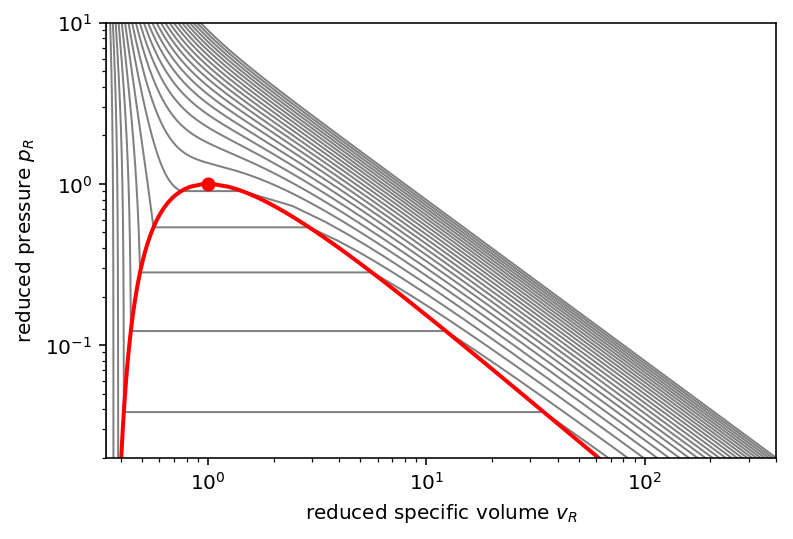

In [11]:
fig2, ax2 = plt.subplots()

temp = np.linspace(0.3, 3, 25)

for t in temp:
    if t>=1.0:
        svol = np.linspace(.01, 1000,100000)
        pres = myeos.pressure_tv(t,svol)
        plt.loglog(svol,pres, color=[0.5,0.5,0.5], linewidth=1)
    else:
        pSat,vl,vg = calcVLE_t(myeos, t)
        svol = np.concatenate((np.linspace(1./3.+0.001, vl, 1000),np.linspace(vg, 1000,1000)))
        pres = myeos.pressure_tv(t,svol)
        plt.loglog(svol,pres, color=[0.5,0.5,0.5], linewidth=1)
        
plt.loglog(1.0,1.0, 'o', color=[1.0, 0.0, 0.0])

vgSat= []
vlSat = []
pSat = []
temp = np.linspace(0.3, 0.999, 80)
for t in temp:
    p,vl,vg = calcVLE_t(myeos, t)
    pSat.append(p)
    vlSat.append(vl)
    vgSat.append(vg)

plt.loglog(vgSat,pSat, '-', color='r', linewidth = 2)
plt.loglog(vlSat,pSat, '-', color='r', linewidth = 2)

plt.xlim(1.0/3.0+0.01,400)  
plt.ylim(0.02,10)
plt.xlabel("reduced specific volume $v_R$")
plt.ylabel("reduced pressure $p_R$");

# Compare/verify to property data base. In this case CoolProp

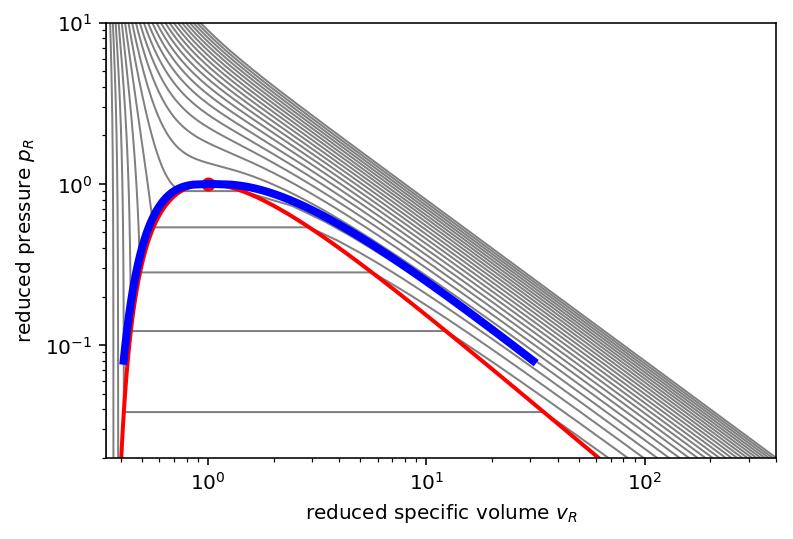

In [12]:
from CoolProp.CoolProp import PropsSI

fluid = "CO2"

def plot_dome(ax, fluid):
    pcr = PropsSI("Pcrit",fluid)
    Tcr = PropsSI("Tcrit",fluid)
    vcr = 1./PropsSI("D", "T", Tcr, 'P', pcr, fluid)

    p = np.linspace(pcr*0.08, pcr, 100)
    f_vl = lambda p: 1./PropsSI("D", "P", p, 'Q', 0.0, fluid)
    f_vv = lambda p: 1./PropsSI("D", "P", p, 'Q', 1.0, fluid)

    vl = np.array(list(map(f_vl, p)))
    vv = np.array(list(map(f_vv, p)))

    ax.plot(vl/vcr,p/pcr, linestyle='-', color='b', linewidth = 4)
    ax.plot(vv/vcr,p/pcr, linestyle='-', color='b', linewidth = 4)
#     return ax

plot_dome(ax2, fluid)
fig2

# Applied example: use CoolProp to calculate COP of a heat pump

# Class (object) for thermodynamic states

In [13]:
class ThermoState():

    def __init__(self, pair, value1, value2, fluid):
        
        self.fluid = fluid
        
        if pair == "TQ":
            self.T = value1
            self.P = PropsSI("P", "T", self.T, "Q", value2, self.fluid)
            self.H = PropsSI("H", "T", self.T, "Q", value2, self.fluid)
            self.S = PropsSI("S", "T", self.T, "Q", value2, self.fluid)

        if pair == "PS":
            self.P = value1
            self.S = value2
            self.H = PropsSI("H", "P", self.P, "S", self.S, self.fluid)
            self.T = PropsSI("T", "P", self.P, "S", self.S, self.fluid)

        if pair == "PH":
            self.P = value1
            self.H = value2
            self.T = PropsSI("T", "P", self.P, "H", self.H, self.fluid)
            self.S = PropsSI("S", "P", self.P, "H", self.H, self.fluid)
            
    def plot_TS(self, ax,color='r', markersize = 8):
        ax.plot(self.S, self.T-273.15, marker='o', color=color, markersize=markersize)

### Test it

In [14]:
ts = ThermoState("TQ", 300, 1, "CO2")
print(ts.P)

6713078.062909933


# Class (object) heat pump 
Takes as parameters: Saturation temperatures at evaporator $T_1$ and condensor $T_3$, and the isentropic efficiency of the compressor $\eta$. 

In [15]:
class HeatPump():
    
    def __init__(self, fluid, T1, T3, eta=0.8):
        
        self.fluid = fluid
        self.calc_states(T1+273.15, T3+273.15, eta)
        self.calc_COP()
        
        
    def calc_states(self, T1, T3, eta):
        
        # Thermodynamic state 1: compressor inlet
        self.ts1 = ThermoState("TQ", T1, 1.0, self.fluid)
        
        # Thermodynamic state 3: condensor outlet
        self.ts3 = ThermoState("TQ", T3, 0.0, self.fluid)
        
        # Thermodynamic state 2: compressor outlet
        self.ts2_is = ThermoState("PS", self.ts3.P, self.ts1.S, self.fluid)
        H2   = (self.ts2_is.H - self.ts1.H)/eta + self.ts1.H
        self.ts2 = ThermoState("PH", self.ts3.P, H2, self.fluid)

        # Thermodynamic state 4: evaporator inlet
        self.ts4 = ThermoState("PH", self.ts1.P, self.ts3.H, self.fluid)

    
    def calc_COP(self):
        
        self.work_in  = self.ts2.H - self.ts1.H
        self.heat_out = self.ts2.H - self.ts3.H  
        self.COP = self.heat_out/self.work_in

    def plot(self, ax, color='r'):
        
        plot_dome(ax, self.fluid, self.ts1.T,color)
        
        self.ts1.plot_TS(ax, color=color)
        self.ts2.plot_TS(ax, color=color)
        self.ts3.plot_TS(ax, color=color)
        self.ts4.plot_TS(ax, color=color)
        
        ax.plot([self.ts1.S,self.ts2.S],[self.ts1.T-273.15, self.ts2.T-273.15], color=color)
        ax.plot(np.linspace(self.ts2.S,self.ts3.S, 100),
                [PropsSI("T","S",s,"P", self.ts2.P, self.fluid)-273.15 
                 for s in np.linspace(self.ts2.S, self.ts3.S,100)],             color=color)
        ax.plot([self.ts3.S,self.ts4.S],[self.ts3.T-273.15, self.ts4.T-273.15], color=color)
        ax.plot(np.linspace(self.ts4.S,self.ts1.S, 100),
                [PropsSI("T","S",s,"P", self.ts4.P, self.fluid)-273.15 
                 for s in np.linspace(self.ts4.S, self.ts1.S,100)],             color=color)

In [16]:
def plot_dome(ax, fluid, Tmin, color='k'):
    
    Tmax = PropsSI("Tcrit", fluid)
    T = np.linspace(Tmin, Tmax, 100)
    fliq = lambda T: PropsSI("S", "T", T, 'Q', 0, fluid)
    fvap = lambda T: PropsSI("S", "T", T, 'Q', 1, fluid)

    Sl = np.array(list(map(fliq, T)))
    Sv = np.array(list(map(fvap, T)))
    
    ax.plot(Sl, T-273.15, linestyle='--', color=color)
    ax.plot(Sv, T-273.15, linestyle='--', color=color)
    return ax

## Instantiate HP with water 

7.232405654958017


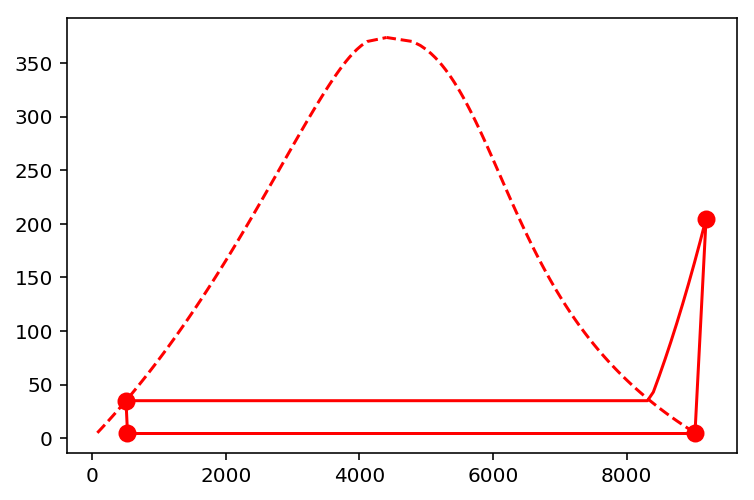

In [18]:
hpWater = HeatPump(fluid = "Water", T1 = 5, T3 = 35)
print(hpWater.COP)
fig, ax = plt.subplots()
hpWater.plot(ax, color='r')

## Instantiate HP with R134a 

7.316396093788192


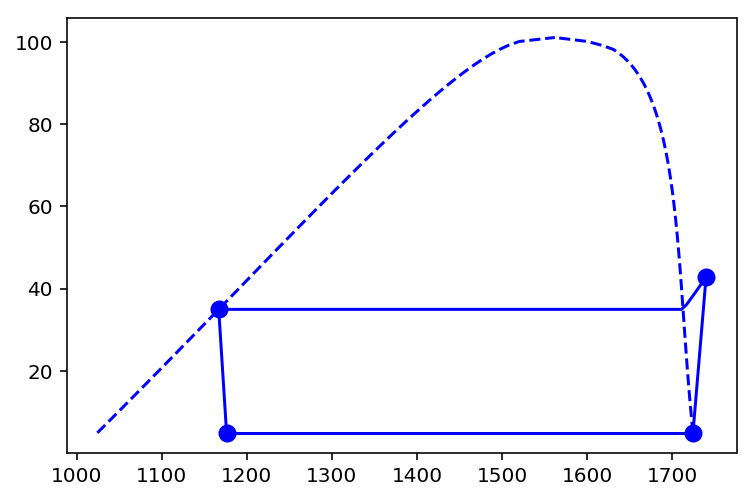

In [19]:
hpR134a = HeatPump(fluid = "R134a", T1 = 5, T3 = 35)
print(hpR134a.COP)
fig, ax = plt.subplots()
hpR134a.plot(ax, color='b')

### plot both

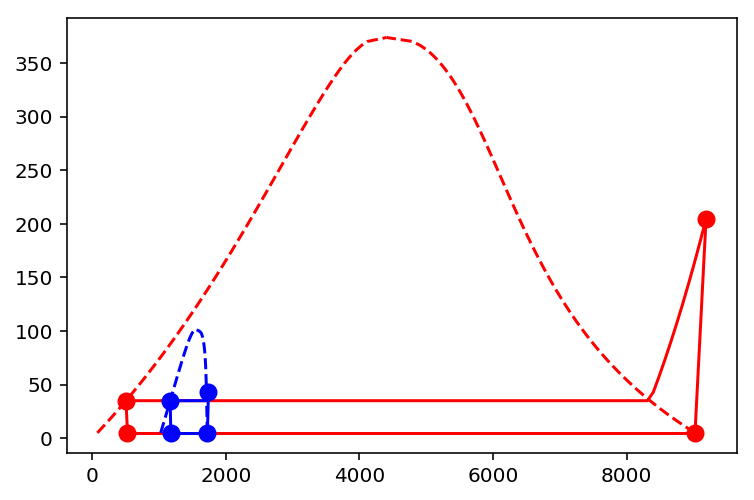

In [20]:
fig, ax = plt.subplots()

hpWater.plot(ax, color='r')
hpR134a.plot(ax, color='b')